#### Importing packages and data

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [111]:
data = pd.read_csv("Ocena subskrypcji.csv", sep=';')

print(data.head(n=5))

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


#### Clean data from outliers

In [112]:
print("Data shape before removing outliers:", data.shape)

def remove_outliers_from_column(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    data = remove_outliers_from_column(data, column)

print("Data shape after removing outliers:", data.shape)

Data shape before removing outliers: (45211, 17)
Data shape after removing outliers: (32756, 17)


#### One-hot encoding & correlation analysis 

C:\Users\filip\AppData\Local\Temp\ipykernel_22832\1871962312.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['y'] = data['y'].replace({'yes': 1, 'no': 0})


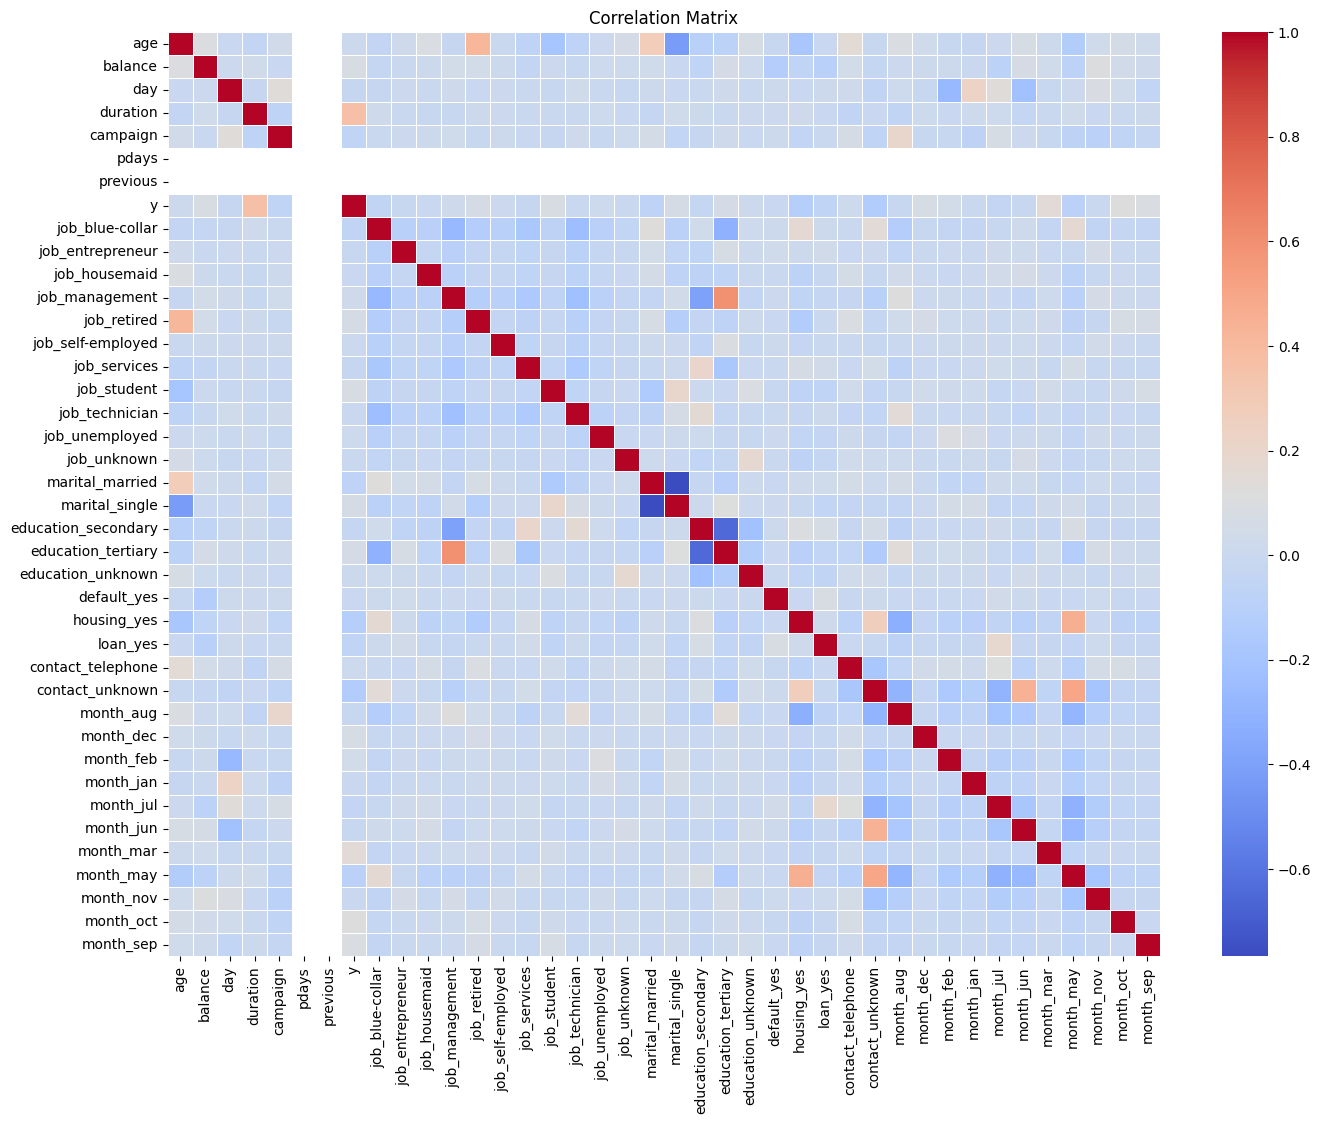

In [113]:
data['y'] = data['y'].replace({'yes': 1, 'no': 0})

non_numeric_columns = data.select_dtypes(exclude=['float64', 'int64']).columns
data_encoded = pd.get_dummies(data, columns=non_numeric_columns, drop_first=True)

correlation_matrix = data_encoded.corr()

plt.figure(figsize=(16, 12))

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Classification modeling - using all of the independent variables and without standard scaler

In [130]:
X = data_encoded.drop('y', axis=1)
y = data_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Accuracy: 0.925
Confusion matrix:
[[5946  120]
 [ 373  113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6066
           1       0.48      0.23      0.31       486

    accuracy                           0.92      6552
   macro avg       0.71      0.61      0.64      6552
weighted avg       0.91      0.92      0.91      6552



c:\AGH - Business Intelligence\BI\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Classification modeling - using all of the independent variables

In [114]:
X = data_encoded.drop('y', axis=1)
y = data_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Accuracy: 0.927
Confusion matrix:
[[5953  113]
 [ 368  118]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6066
           1       0.51      0.24      0.33       486

    accuracy                           0.93      6552
   macro avg       0.73      0.61      0.65      6552
weighted avg       0.91      0.93      0.91      6552



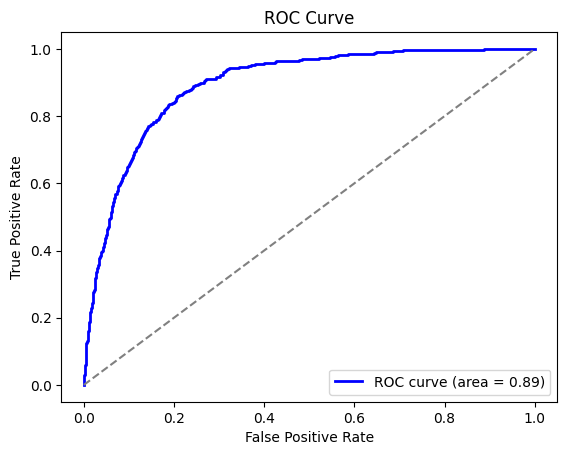

In [115]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#### Classification modeling - using independent variables with correlation to `y` >0.1 or <-0.1

In [116]:
X = data_encoded.drop('y', axis=1)
y = data_encoded['y']

correlations = data_encoded.corr()["y"].drop("y")

selected_features = correlations[abs(correlations) > 0.1].index

X_selected = data_encoded[selected_features]
y = data_encoded["y"]

print(f"Wybrane cechy: {list(selected_features)}")

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Wybrane cechy: ['duration', 'housing_yes', 'contact_unknown', 'month_mar', 'month_oct']
Accuracy: 0.925
Confusion matrix:
[[5959  107]
 [ 387   99]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6066
           1       0.48      0.20      0.29       486

    accuracy                           0.92      6552
   macro avg       0.71      0.59      0.62      6552
weighted avg       0.91      0.92      0.91      6552



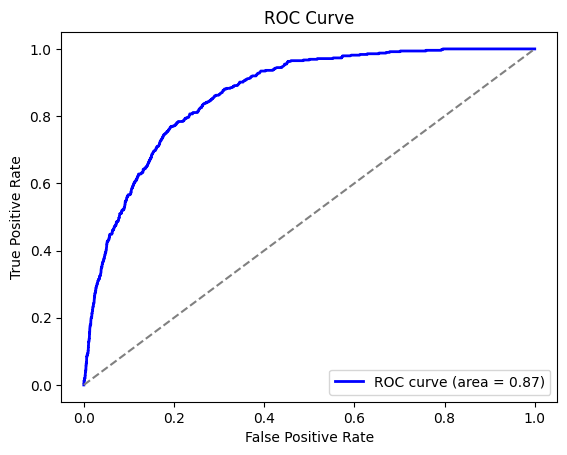

In [117]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#### Classification modeling - using PCA method to reduce number of dimensions

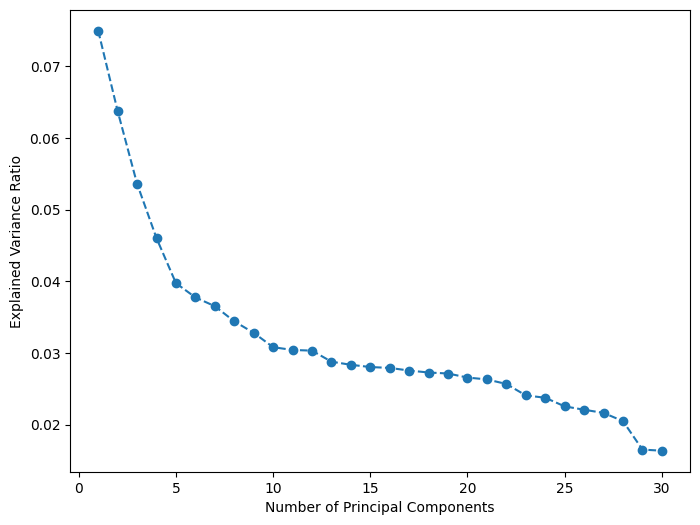

Number of components PCA: 30


In [107]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded.drop("y", axis=1))
y = data_encoded["y"]

pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, X_pca.shape[1] + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

print(f"Number of components PCA: {X_pca.shape[1]}")

In [123]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded.drop("y", axis=1))
y = data_encoded["y"]

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components PCA: {X_pca.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Number of components PCA: 5
Accuracy: 0.93

Confusion Matrix:
[[6054   12]
 [ 479    7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6066
           1       0.37      0.01      0.03       486

    accuracy                           0.93      6552
   macro avg       0.65      0.51      0.49      6552
weighted avg       0.89      0.93      0.89      6552



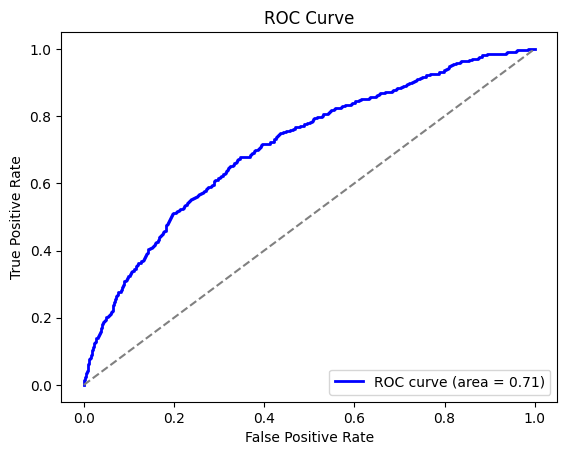

In [124]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#### Classification modeling - using PCA method to reduce number of dimensions and equalization of the number of objects belonging to `y` class

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded.drop("y", axis=1))
y = data_encoded["y"]

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components PCA: {X_pca.shape[1]}")

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train_bal, y_train_bal)


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Number of components PCA: 5
Accuracy: 0.86

Confusion Matrix:
[[5493  573]
 [ 335  151]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      6066
           1       0.21      0.31      0.25       486

    accuracy                           0.86      6552
   macro avg       0.58      0.61      0.59      6552
weighted avg       0.89      0.86      0.87      6552



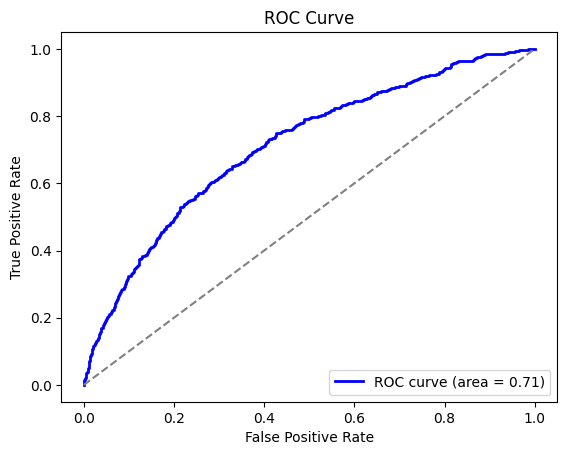

In [126]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [129]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded.drop("y", axis=1))
y = data_encoded["y"]

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components PCA: {X_pca.shape[1]}")

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train_bal, y_train_bal)


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Number of components PCA: 10
Accuracy: 0.85

Confusion Matrix:
[[5429  637]
 [ 314  172]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6066
           1       0.21      0.35      0.27       486

    accuracy                           0.85      6552
   macro avg       0.58      0.62      0.59      6552
weighted avg       0.89      0.85      0.87      6552

